## 第6章: 機械学習  
本章では，Fabio Gasparetti氏が公開しているNews Aggregator Data Setを用い，ニュース記事の見出しを「ビジネス」「科学技術」「エンターテイメント」「健康」のカテゴリに分類するタスク（カテゴリ分類）に取り組む．

In [2]:
path="./Section_6/NewsAggregatorDataset/newsCorpora.csv"

50. データの入手・整形  
News Aggregator Data Setをダウンロードし、以下の要領で学習データ（train.txt），検証データ（valid.txt），評価データ（test.txt）を作成せよ．  
  1. ダウンロードしたzipファイルを解凍し，readme.txtの説明を読む．  
  2. 情報源（publisher）が”Reuters”, “Huffington Post”, “Businessweek”, “Contactmusic.com”, “Daily Mail”の事例（記事）のみを抽出する．  
  3. 抽出された事例をランダムに並び替える．  
  4. 抽出された事例の80%を学習データ，残りの10%ずつを検証データと評価データに分割し，それぞれtrain.txt，valid.txt，test.txtというファイル名で保存する．  
  
  ファイルには，１行に１事例を書き出すこととし，カテゴリ名と記事見出しのタブ区切り形式とせよ（このファイルは後に問題70で再利用する）．  
学習データと評価データを作成したら，各カテゴリの事例数を確認せよ．

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from functools import reduce

In [4]:
# 2. 事例の抽出
news_corpora = pd.read_csv(path,sep='\t',header=None)
# news_corpora.columns = ['ID','TITLE','URL','PUBLISHER','CATEGORY','STORY','HOSTNAME','TIMESTAMP']
news_corpora.rename(
    columns={
        0:"ID",
        1:"TITLE",
        2:"URL",
        3:"PUBLISHER",
        4:"CATEGORY",
        5:"STORY",
        6:"HOSTNAME",
        7:"TIMESTAMP"
    },
    inplace=True
)

publisher = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
# publisherの要素に対しての真偽
ls_is_specified = [news_corpora.PUBLISHER == p for p in publisher]

# 一つのSeriesに集約
is_specified =reduce(lambda a, b: a | b, ls_is_specified)# reduce:畳み込み
df = news_corpora[is_specified]

In [5]:
#  3. 並び替え
df = df.sample(frac=1) # 全てをサンプリングするので、並び替えと等価

In [6]:
# 4.保存
train_df, valid_test_df = train_test_split(df, test_size=0.2) # 8:2
valid_df, test_df = train_test_split(valid_test_df, test_size=0.5) # 8:1:1
train_df.to_csv('./Section_6/train.txt', columns = ['CATEGORY','TITLE'], sep='\t',header=False, index=False)
valid_df.to_csv('./Section_6/valid.txt', columns = ['CATEGORY','TITLE'], sep='\t',header=False, index=False)
test_df.to_csv('./Section_6/test.txt', columns = ['CATEGORY','TITLE'], sep='\t',header=False, index=False)

In [7]:
#  事例数の確認
df['CATEGORY'].value_counts()

b    5627
e    5279
t    1524
m     910
Name: CATEGORY, dtype: int64

51. 特徴量抽出  
学習データ，検証データ，評価データから特徴量を抽出し，それぞれtrain.feature.txt，valid.feature.txt，test.feature.txtというファイル名で保存せよ． なお，カテゴリ分類に有用そうな特徴量は各自で自由に設計せよ．記事の見出しを単語列に変換したものが最低限のベースラインとなるであろう．

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

In [9]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['TITLE'])
np.savetxt('./Section_6/train.feature.txt', X_train.toarray(), fmt='%d') # スパース行列から密行列に変換

In [10]:
X_valid = vectorizer.transform(valid_df['TITLE'])
X_test = vectorizer.transform(test_df['TITLE'])
np.savetxt('./Section_6/valid.feature.txt', X_valid.toarray(), fmt='%d')
np.savetxt('./Section_6/test.feature.txt', X_test.toarray(), fmt='%d')

52. 学習  
51で構築した学習データを用いて，ロジスティック回帰モデルを学習せよ．

In [11]:
from sklearn.linear_model import LogisticRegression

In [12]:
clf = LogisticRegression()
clf.fit(X_train, train_df['CATEGORY'])

/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# ↑収束しているか判定するパラメータを指定してないから警告？
# https://teratail.com/questions/147028

53. 予測  
52で学習したロジスティック回帰モデルを用い，与えられた記事見出しからカテゴリとその予測確率を計算するプログラムを実装せよ．

In [14]:
dic = {'b':'business', 't':'science and technology', 'e' : 'entertainment', 'm' : 'health'}           
def predict(text):
    text = [text]
    
    """VVVVVV"""
    X = vectorizer.transform(text)    
    ls_proba = clf.predict_proba(X)
    """AAAAAA"""
    
    for proba in ls_proba:
        for c, p in zip(clf.classes_, proba):
            print ("{0:5.2f}%\t:{1}".format(100*p, dic[c]))

In [15]:
s = train_df.iloc[0]['TITLE']
print(s)

The Final Trailer For 'X-Men: Days Of Future Past Is A Traveler Of Both Time  ...


In [16]:
predict(s)

 0.77%	:business
98.30%	:entertainment
 0.75%	:health
 0.19%	:science and technology


54. 正解率の計測  
52で学習したロジスティック回帰モデルの正解率を，学習データおよび評価データ上で計測せよ．

In [17]:
from sklearn.metrics import accuracy_score

In [18]:
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
y_train = train_df['CATEGORY']
y_test = test_df['CATEGORY']
print ("{0:5.2f}%".format(100*accuracy_score(y_train, y_train_pred)))
print ("{0:5.2f}%".format(100*accuracy_score(y_test, y_test_pred)))

99.55%
90.85%


55. 混同行列の作成  
52で学習したロジスティック回帰モデルの混同行列（confusion matrix）を，学習データおよび評価データ上で作成せよ．

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
print (confusion_matrix(y_train, y_train_pred, labels=['b','t','e','m']))
print (confusion_matrix(y_test, y_test_pred, labels=['b','t','e','m']))

[[4490    5    4    0]
 [  18 1195    5    0]
 [   8    2 4229    1]
 [   3    0    2  710]]
[[522  13  15   2]
 [ 23 112  15   1]
 [ 14   1 509   0]
 [ 10   5  23  69]]


56. 適合率，再現率，F1スコアの計測  
52で学習したロジスティック回帰モデルの適合率，再現率，F1スコアを，評価データ上で計測せよ．カテゴリごとに適合率，再現率，F1スコアを求め，カテゴリごとの性能をマイクロ平均（micro-average）とマクロ平均（macro-average）で統合せよ．

In [21]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [22]:
print (precision_score(y_test, y_test_pred, average=None, labels=['b','t','e','m']))
print (recall_score(y_test, y_test_pred, average=None, labels=['b','t','e','m']))
print (f1_score(y_test, y_test_pred, average=None, labels=['b','t','e','m']))

[0.91739895 0.85496183 0.90569395 0.95833333]
[0.94565217 0.74172185 0.97137405 0.64485981]
[0.93131133 0.79432624 0.9373849  0.77094972]


In [23]:
# TPFPTNFNの個数から
print ("{0:5.2f}%".format(100*precision_score(y_test, y_test_pred, average='micro', labels=['b','t','e','m'])))
print ("{0:5.2f}%".format(100*recall_score(y_test, y_test_pred, average='micro', labels=['b','t','e','m'])))
print ("{0:5.2f}%".format(100*f1_score(y_test, y_test_pred, average='micro', labels=['b','t','e','m'])))

90.85%
90.85%
90.85%


In [24]:
print ("{0:5.2f}%".format(100*precision_score(y_test, y_test_pred, average='macro', labels=['b','t','e','m'])))
print ("{0:5.2f}%".format(100*recall_score(y_test, y_test_pred, average='macro', labels=['b','t','e','m'])))
print ("{0:5.2f}%".format(100*f1_score(y_test, y_test_pred, average='macro', labels=['b','t','e','m'])))

90.91%
82.59%
85.85%


In [25]:
# Posの個数で加重平均
print ("{0:5.2f}%".format(100*precision_score(y_test, y_test_pred, average='weighted', labels=['b','t','e','m'])))
print ("{0:5.2f}%".format(100*recall_score(y_test, y_test_pred, average='weighted', labels=['b','t','e','m'])))
print ("{0:5.2f}%".format(100*f1_score(y_test, y_test_pred, average='weighted', labels=['b','t','e','m'])))

90.90%
90.85%
90.53%


In [26]:
# マルチラベル分類器の評価指標(Micro-F1/Macro-F1)の振る舞い
# https://qiita.com/TaskeHAMANO/items/120cabf01b299b8f35ce
# https://note.nkmk.me/python-sklearn-confusion-matrix-score/

57. 特徴量の重みの確認  
52で学習したロジスティック回帰モデルの中で，重みの高い特徴量トップ10と，重みの低い特徴量トップ10を確認せよ．

In [27]:
names = np.array(vectorizer.get_feature_names())
# labels=['b','t','e','m']
for c, coef in zip(clf.classes_, clf.coef_): # [カテゴリ, モデル]毎に表示する
    idx = np.argsort(coef)[::-1] # 大きい順[モデル]の特徴量の重みのidx array
    print (dic[c])
    print (names[idx][:10]) # 重みの高い特徴量トップ10
    print (names[idx][-10:][::-1]) # 重みの低い特徴量トップ10

business
['bank' 'fed' 'ukraine' 'obamacare' 'ecb' 'china' 'euro' 'yellen'
 'argentina' 'dollar']
['aereo' 'ebola' 'twitch' 'activision' 'subscription' 'nintendo' 'she'
 'heartbleed' 'researchers' 'pump']
entertainment
['kardashian' 'chris' 'paul' 'thrones' 'miley' 'cyrus' 'hbo' 'trailer'
 'wedding' 'film']
['google' 'china' 'gm' 'facebook' 'microsoft' 'data' 'ebola' 'study'
 'billion' 'obamacare']
health
['ebola' 'cancer' 'fda' 'drug' 'mers' 'study' 'doctors' 'cdc' 'cases'
 'cigarettes']
['gm' 'dimon' 'facebook' 'twitter' 'shows' 'apple' 'google' 'sales'
 'climate' 'bank']
science and technology
['facebook' 'google' 'apple' 'microsoft' 'climate' 'heartbleed' 'tesla'
 'nasa' 'gm' 'fcc']
['stocks' 'percent' 'grows' 'should' 'fed' 'american' 'valued' 'move'
 'thrones' 'drug']


58. 正則化パラメータの変更  
ロジスティック回帰モデルを学習するとき，正則化パラメータを調整することで，学習時の過学習（overfitting）の度合いを制御できる．異なる正則化パラメータでロジスティック回帰モデルを学習し，学習データ，検証データ，および評価データ上の正解率を求めよ．実験の結果は，正則化パラメータを横軸，正解率を縦軸としたグラフにまとめよ．

In [28]:
import matplotlib.pyplot as plt

In [29]:
def calc_scores(c):
    y_train = train_df['CATEGORY']
    y_valid = valid_df['CATEGORY']
    y_test = test_df['CATEGORY']
    
    """
    penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
    Used to specify the norm used in the penalization. The ‘newton-cg’, ‘sag’ and ‘lbfgs’ solvers support only l2 penalties. ‘elasticnet’ is only supported by the ‘saga’ solver. If ‘none’ (not supported by the liblinear solver), no regularization is applied.
    New in version 0.19: l1 penalty with SAGA solver (allowing ‘multinomial’ + L1)
    
    C:float, default=1.0
    Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
    """
    clf = LogisticRegression(C=c)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_valid_pred = clf.predict(X_valid)
    y_test_pred = clf.predict(X_test)
    
    scores = []
    scores.append(accuracy_score(y_train, y_train_pred))
    scores.append(accuracy_score(y_valid, y_valid_pred))
    scores.append(accuracy_score(y_test, y_test_pred))
    return scores

In [30]:
# array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,1.e+03, 1.e+04])
C = np.logspace(-5, 4, 10, base=10)
scores = []
for c in C:
    scores.append(calc_scores(c))
scores = np.array(scores).T

/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi

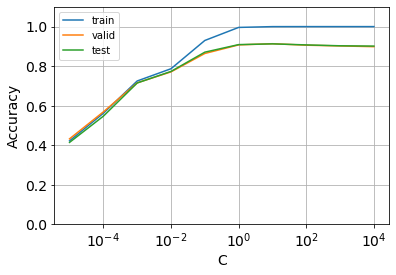

In [31]:
labels = ['train', 'valid', 'test']
for score, label in zip(scores,labels):
    plt.plot(C, score, label=label)
plt.ylim(0, 1.1)
plt.xscale('log')
plt.xlabel('C', fontsize = 14)
plt.ylabel('Accuracy', fontsize = 14)
plt.tick_params(labelsize=14)
plt.grid(True)
plt.legend()

59. ハイパーパラメータの探索  
学習アルゴリズムや学習パラメータを変えながら，カテゴリ分類モデルを学習せよ．検証データ上の正解率が最も高くなる学習アルゴリズム・パラメータを求めよ．また，その学習アルゴリズム・パラメータを用いたときの評価データ上の正解率を求めよ．

In [32]:
import itertools

In [33]:
def calc_scores(C,solver,class_weight):
    y_train = train_df['CATEGORY']
    y_valid = valid_df['CATEGORY']
    y_test = test_df['CATEGORY']
    
    clf = LogisticRegression(C=C, solver=solver, class_weight=class_weight)
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    y_valid_pred = clf.predict(X_valid)
    y_test_pred = clf.predict(X_test)
    
    scores = []
    scores.append(accuracy_score(y_train, y_train_pred))
    scores.append(accuracy_score(y_valid, y_valid_pred))
    scores.append(accuracy_score(y_test, y_test_pred))
    return scores

In [35]:
C = np.logspace(-5, 4, 10, base=10)
solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
class_weight = [None, 'balanced']
best_parameter = None
best_scores = None
max_valid_score = 0
for c, s, w in itertools.product(C, solver, class_weight):
    # print(c, s, w)
    scores = calc_scores(c, s, w)
    # print (scores)
    if scores[1] > max_valid_score:
        max_valid_score = scores[1]
        best_parameter = [c, s, w]
        best_scores = scores
print ('best patameter: ', best_parameter)
print ('best scores: ', best_scores)
print ('test accuracy: ', best_scores[2])

/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The m

/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
P

best patameter:  [1.0, 'liblinear', 'balanced']
best scores:  [0.990723388305847, 0.9145427286356822, 0.9122938530734632]
test accuracy:  0.9122938530734632


/opt/conda/envs/py37/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
